# Анализ схожести научных текстов с помощью методов естественной обработки языка и машинного обучения
## Береза Анастасия 
## Учебная группа о.ИЗДтс 23.2/Б3-22

## 1. Установка зависимостей


In [1]:
# При первом запуске раскомментировать строку ниже

# %pip install tensorflow kagglehub pandas numpy scikit-learn joblib tqdm psutil nltk pymorphy3 matplotlib


## 2. Импорт библиотек


In [2]:
import kagglehub
import os
import shutil

from pathlib import Path
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import tee

f:\PDipPraktika\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Загрузка датасета

In [3]:
path = kagglehub.dataset_download("ergkerg/russian-scientific-articles")
print("Path to dataset files:", path)

# Копирование в папку проекта

destination_path = os.path.join(os.getcwd(), "russian-scientific-articles")
shutil.copytree(path, destination_path, dirs_exist_ok=True)

print("Файлы датасета перенесены в:", destination_path)

Path to dataset files: C:\Users\Basss\.cache\kagglehub\datasets\ergkerg\russian-scientific-articles\versions\1
Файлы датасета перенесены в: f:\PDipPraktika\russian-scientific-articles


## 4. Анализ набора данных

In [4]:
# Сбор датасета из txt-файлов

rows = []
for root in ["russian-scientific-articles/data_3", "russian-scientific-articles/data_3_1"]:
    for p in Path(root).rglob("*.txt"):
        rows.append({
            "category": p.parent.name,
            "file": str(p),
            "text": p.read_text(encoding="utf-8", errors="ignore")
        })

df = pd.DataFrame(rows)
print(df.shape)


(2478, 3)


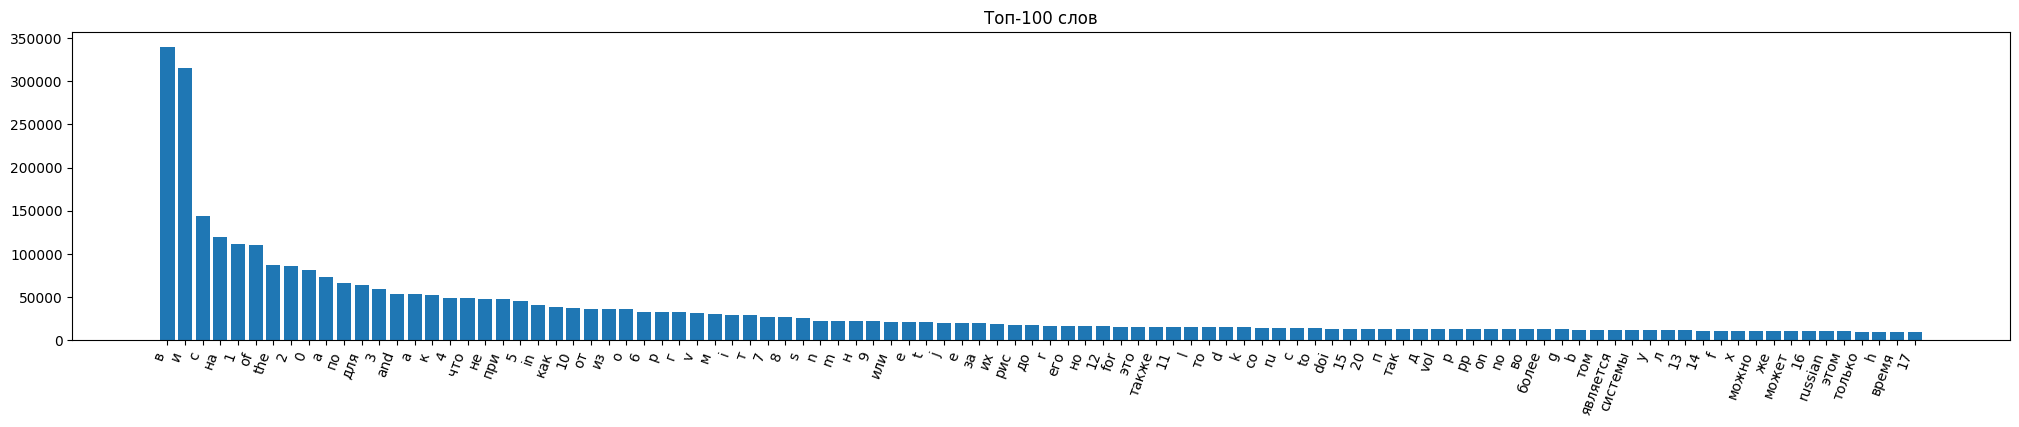

Топ 50-биграмм
of the: 24729
doi 10: 9155
in the: 8729
и в: 8118
а также: 8025
1 2: 7092
при этом: 6221
а в: 5609
1 1: 5545
на основе: 5528
в том: 5412
и др: 5240
et al: 5093
0 0: 4930
в качестве: 4922
in russian: 4545
0 1: 4539
2 2: 4514
on the: 4458
e mail: 4302
таким образом: 4230
так и: 4200
journal of: 4148
на рис: 4093
1 0: 4058
т е: 4027
in russ: 3849
что в: 3825
2 3: 3709
и т: 3686
может быть: 3568
не только: 3500
в в: 3411
2 1: 3361
в рамках: 3268
в результате: 3243
а а: 3234
рис 1: 3230
с помощью: 3127
но и: 3117
в а: 3103
2 0: 3099
том что: 3087
том числе: 3029
в россии: 3006
в виде: 3004
рис 2: 2888
в этом: 2871
org 10: 2860
0 5: 2809


In [5]:
# Извлечение слов из всех статей

def raw_tokens(text):
    return re.findall(r"\w+", str(text).lower())

tokens = []
for article in df["text"].dropna():
    tokens.extend(raw_tokens(article))

# Гистограмма для топ-100 слов

top_n = 100
freq = Counter(tokens).most_common(top_n)
words, counts = zip(*freq)

plt.figure(figsize=(25,4))
plt.bar(words, counts)
plt.xticks(rotation=70, ha="right")
plt.title("Топ-100 слов")
plt.show()

# Топ пар из 2 слов 

def bigrams(seq):
    a, b = tee(seq)
    next(b, None)
    return zip(a, b)

bigram_freq = Counter(bigrams(tokens)).most_common(50)
print("Топ 50-биграмм")
for (w1, w2), c in bigram_freq:
    print(f"{w1} {w2}: {c}")
